In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
repo_dir = Path('../..')

In [4]:
if str(repo_dir) not in sys.path:
    sys.path.append(str(repo_dir))
    
from analysis.curve_fitting.src.fitting_functions import LOSS_FUNCTIONS
from analysis.curve_fitting.src.utils import apply_filters, load_yaml, convert_loss_parameters, convert_loss_parameters_batch

from visualization.src.utils import COLOR_PALETTES, save_figs
from visualization.src.visualize import plot_reg, plot_reg_bivariate, plot_confidence_intervals



In [5]:
args = {
    'results_csv': repo_dir / 'results' / 'benchmark_scores_local.csv',
}

In [6]:
results_csv = args['results_csv']

df_results = pd.read_csv(results_csv)
df_results['total_flops'] = df_results['flops'] * df_results['n_samples_seen']

## Load Experiment Configuration

In [7]:
analysis_dir = repo_dir / 'analysis'
results_dir = analysis_dir / 'curve_fitting/fitting_results'

In [8]:
yaml_config_behavior = analysis_dir / 'curve_fitting/configs/compute/compute_behavior.yaml'
yaml_config_neuro = analysis_dir / 'curve_fitting/configs/compute/compute_neuro.yaml'


config_behavior = load_yaml(yaml_config_behavior)
config_neuro = load_yaml(yaml_config_neuro)

In [9]:
L_fit = config_neuro['fitting_parameters']['loss_function']
L_viz = config_neuro['visualization']['loss_function']
x_scaler = float(config_behavior['fitting_parameters'].get('X_scaler', 1e13))

assert L_fit == config_behavior['fitting_parameters']['loss_function']
assert L_viz == config_behavior['visualization']['loss_function']


## Apply Data Filters

In [10]:
df_behavior = apply_filters(df_results, config_behavior.get('data_filters', {}))
df_neuro = apply_filters(df_results, config_neuro.get('data_filters', {}))

## Load Fitting Results

#### Neuro

In [11]:
experiment_name = 'compute_neuro'
with open(results_dir / experiment_name / 'results.pkl', 'rb') as f:
    results_neuro = pickle.load(f)

optimized_params_neuro = convert_loss_parameters(results_neuro['optimized_parameters'], L_fit, L_viz)

# Convert bootstrapped parameters
opt_params_boot_neuro = results_neuro['optimized_parameters_bootstrapped']
opt_params_boot_neuro = convert_loss_parameters_batch(
    params=opt_params_boot_neuro,
    src_loss=L_fit,
    dst_loss=L_viz
)

#### Behavior

In [12]:
experiment_name = 'compute_behavior'
with open(results_dir / experiment_name / 'results.pkl', 'rb') as f:
    results_behavior = pickle.load(f)
    
optimized_params_behavior = convert_loss_parameters(results_behavior['optimized_parameters'], L_fit, L_viz)

# Convert bootstrapped parameters
opt_params_boot_behavior = results_behavior['optimized_parameters_bootstrapped']
opt_params_boot_behavior = convert_loss_parameters_batch(
    params=opt_params_boot_behavior,
    src_loss=L_fit,
    dst_loss=L_viz
)

## Visualize

#### Plotting settings

In [13]:
X = df_neuro.total_flops.values / x_scaler
L = LOSS_FUNCTIONS[L_viz]

fig_multiplier = 0.75
fig_multiplier = 0.5
x_extend = 10
X_str = r'$$\tilde{C}$$'
linewidth = 3.0
alpha_scatter = 0.2
alpha_ci = 0.2
alpha_fit = 1.0
figsize = (12, 8)
figsize = (fig_multiplier * figsize[0], fig_multiplier * figsize[1])

color_palaette = COLOR_PALETTES['regions']
color_1, color_2 = color_palaette[0], color_palaette[-1]

#### Plot

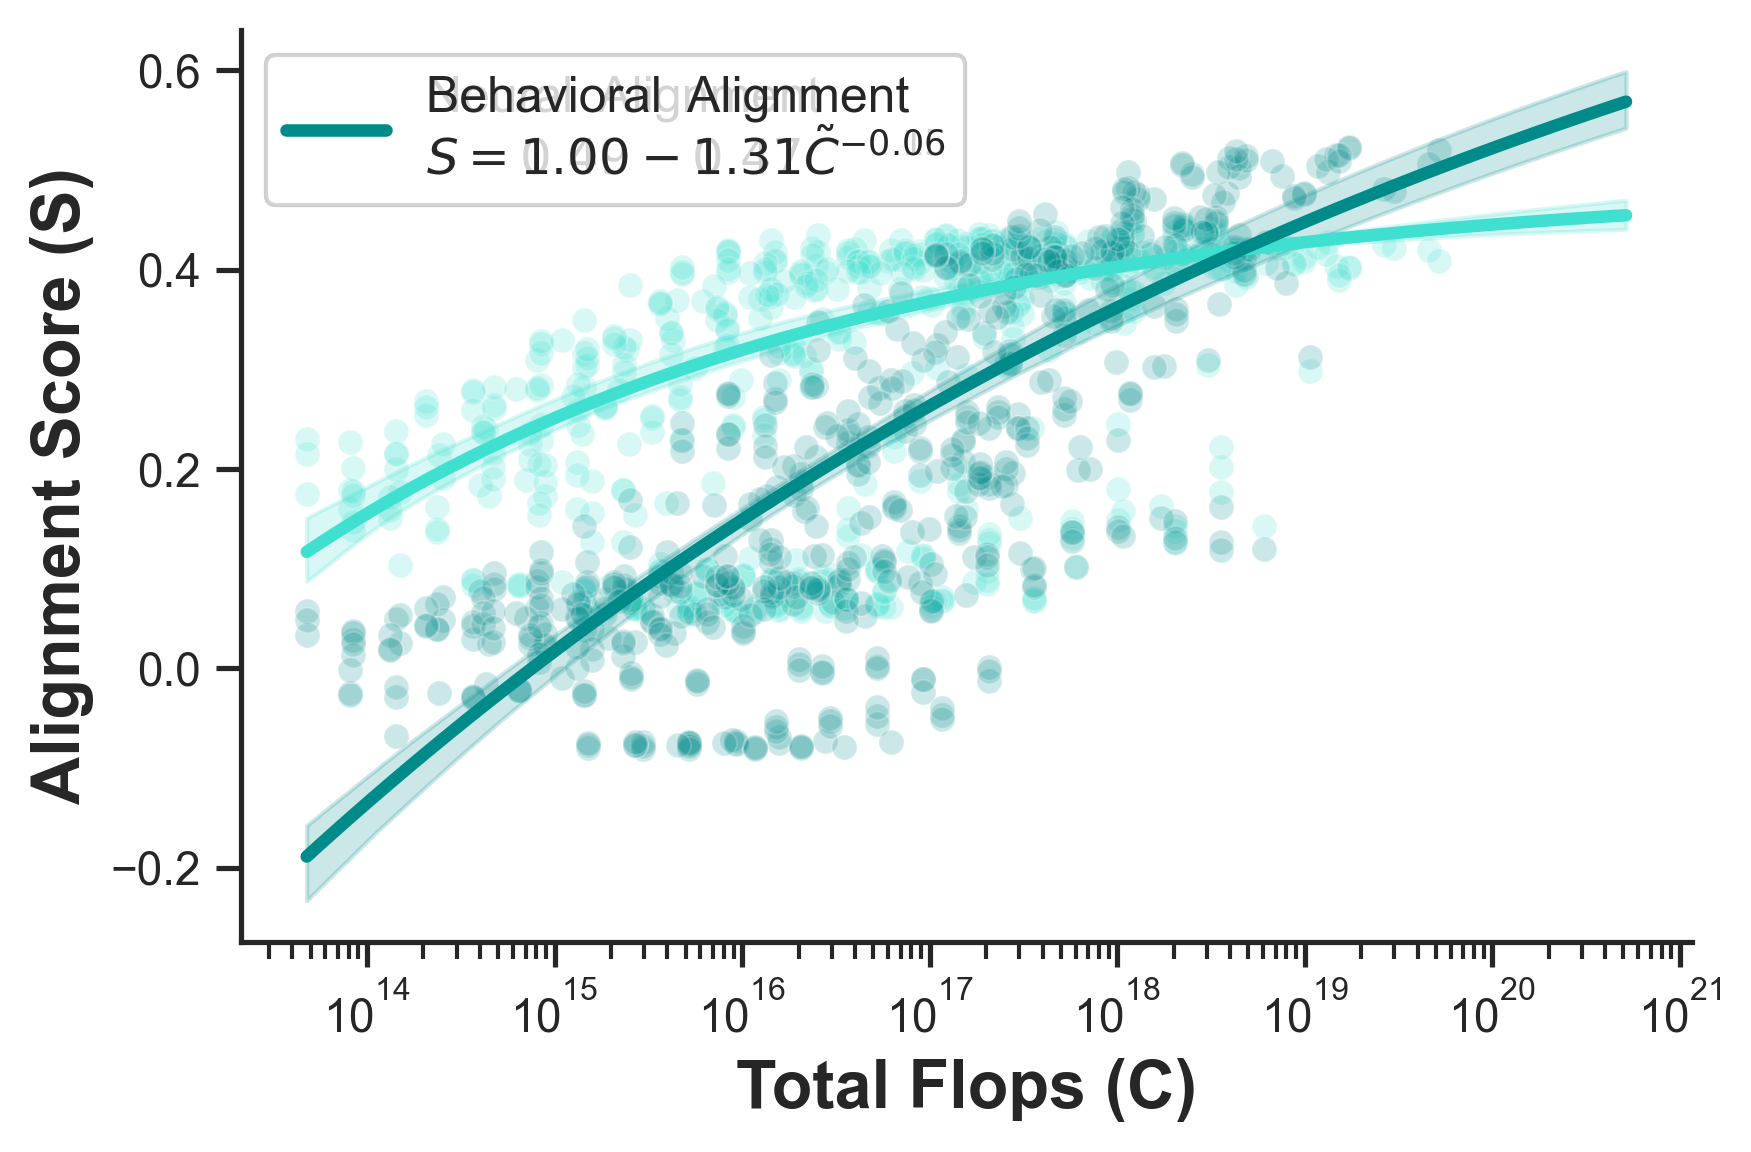

In [14]:
sns.set_theme(style='whitegrid')
sns.set_theme(style='ticks')


fig, axes = plt.subplots(1, 1, figsize=figsize, dpi=300)
ax = axes

### Neuro
df_region = df_neuro
color = color_1
sns.scatterplot(data=df_region, x='total_flops', y='score', ax=ax, color=color, alpha=alpha_scatter)
plot_reg(X, optimized_params_neuro, L, ax, color=color, x_extend=x_extend, linestyle='-', X_str=X_str, x_scaler=x_scaler, show_x_scaler=False, linewidth=linewidth, legend=False, alpha=alpha_fit)
plot_confidence_intervals(X, opt_params_boot_neuro, L, ax, color=color, x_scaler=x_scaler, x_extend=x_extend, percentile=95.0, invert_y=True, alpha=alpha_ci)

### Behavioral
df_region = df_behavior
color = color_2
sns.scatterplot(data=df_region, x='total_flops', y='score', ax=ax, color=color, alpha=alpha_scatter)
plot_reg(X, optimized_params_behavior, L, ax, color=color, x_extend=x_extend, linestyle='-', X_str=X_str, x_scaler=x_scaler, show_x_scaler=False, linewidth=linewidth, legend=False, alpha=alpha_fit)
plot_confidence_intervals(X, opt_params_boot_behavior, L, ax, color=color, x_scaler=x_scaler, x_extend=x_extend, percentile=95.0, invert_y=True, alpha=alpha_ci)


### Formatting
ax.set_xscale('log')
ax.set_xlabel('FLOPs')
ax.set_ylabel('Alignment')
ax.set_xlabel('Total Flops (C)', fontsize=16, fontweight='bold')
ax.set_ylabel('Alignment Score (S)', fontsize=16, fontweight='bold')
# ax = set_ticks(ax, xticks_mode='log', yticks_mode=None, yticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
# ax.set_ylim(0, 0.6)
ax.grid(False)

### Legend
handles, labels = ax.get_legend_handles_labels()
labels = [
    'Neural  Alignment\n' + labels[0],
    'Behavioral  Alignment\n'  + labels[1]
]
l1 = ax.legend([handles[0]], [labels[0]], fontsize=12)
l2 = ax.legend([handles[1]], [labels[1]], fontsize=12)
ax.add_artist(l1)
# ax.legend(handles, labels)

ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()


figures_dir = '../figures'
fig_name = 'fig1_compute_behavior_vs_neuro'
formats = ['pdf', 'png', 'svg']
save_figs(figures_dir, fig_name, formats=formats)